In [1]:
import keras

Using TensorFlow backend.
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import getLines

In [3]:
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import numpy as np
import cv2
import scipy
from scipy import ndimage
import random
def getLatestTrack(idx = -1):
    dir_ = "../CameraMotionLogger/Server/website/uploads/"
    #file = sorted(os.listdir(dir_))[-10]
    file = sorted(os.listdir(dir_))[idx]
    return os.path.join(dir_, file)
getLatestTrack()

imagesDir = "../CameraMotionLogger/Server/website/image_uploads/"
web_images_Dir = "../webgrid/image_uploads/"

ultrasoundDir = "../neuralnet/fastNNServer/outputs/"

static_pictures = os.listdir(imagesDir)[1:]
web_static_pictures = os.listdir(web_images_Dir)[1:]

def true_random_image():
    p = random.choice(static_pictures)
    return np.rot90(np.array(Image.open(imagesDir + p)), 3)

def true_random_web_image():
    p = random.choice(web_static_pictures)
    return np.rot90(np.array(Image.open(web_images_Dir + p)), 3)

class TrackedUS:
    def __init__(self, filename):
        self.track = np.array(pickle.load(open(filename, "rb"))).transpose()
        self.time = self.track[3]
        self.startTime = self.time[0]
        self.endTime = self.time[-1]
        
        #load camera pictures for tracking
        pictures = os.listdir(imagesDir)[1:]

        self.p_timestamps = []

        self.p_arrays = []
        for p in pictures:
            t_float = float(p[:-4])
            if self.startTime < t_float < self.endTime:
                try:
                    self.p_timestamps.append(t_float)
                    self.p_arrays.append(np.rot90(np.array(Image.open(imagesDir + p)), 3))
                except OSError:
                    print("bad image", p)
        #load ultrasound images
        
        for us in os.listdir(ultrasoundDir):
            usStart, usEnd = [float(timeStamp) for timeStamp in us.split("_")]
            
            if usStart < self.startTime < self.endTime < usEnd:
                print("yay")
                self.ultrasound = pickle.load(open(ultrasoundDir + us, "rb"))
                break
        else:
            print("no ultrasound found that covers the time of the track")
            
    
    def getAttitudeFromTimestamp(self, t):
        track = self.track
        return [np.interp([t], track[3], track[0]), 
                np.interp([t], track[3], track[1]),
                np.interp([t], track[3], track[2])]
    
    def playUS(self):
        for el in self.ultrasound:
            cv2.imshow("ultra", el[1])
            cv2.waitKey(10)
    def playVideo(self):
        for arr in self.p_arrays:
            cv2.imshow("ultra", arr)
            cv2.waitKey(10)
    def play(self):
        us_index = 0
        video_index = 0
        try:
            while True:
                if self.p_timestamps[video_index] < self.ultrasound[us_index][0]:
                    cv2.imshow("vid", self.p_arrays[video_index])
                    cv2.waitKey(10)
                    video_index += 1
                else:
                    cv2.imshow("ultra", self.ultrasound[us_index][1])
                    cv2.waitKey(10)
                    us_index += 1
        except IndexError:
            print(us_index, video_index)
        print(done)
    def play2(self):
        us_index = 0
        video_index = 0
        try:
            while True:
                
                if self.p_timestamps[video_index] < self.ultrasound[us_index][0]:
                    arr = self.p_arrays[video_index][::3, ::3]
                    v_timestamp = self.p_timestamps[video_index]
                    out = scipy.ndimage.rotate(arr, 
                        -self.getAttitudeFromTimestamp(v_timestamp)[1] * 360 / (2 * np.pi))
                    cv2.imshow("vid", out)
                    cv2.waitKey(10)
                    video_index += 1
                else:
                    arr = self.ultrasound[us_index][1][::3, ::3]
                    u_timestamp = self.ultrasound[us_index][0]
                    out = scipy.ndimage.rotate(arr, 
                        -self.getAttitudeFromTimestamp(u_timestamp)[1] * 360 / (2 * np.pi))
                    cv2.imshow("ultra", out)
                    cv2.waitKey(10)
                    us_index += 1
        except IndexError:
            print(us_index, video_index)
        print("done")



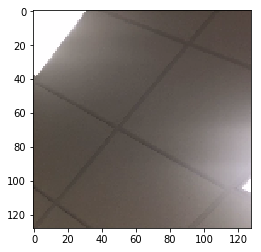

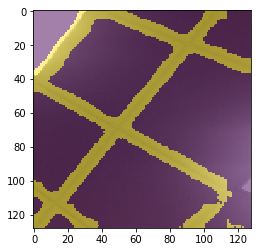

(128, 128) (320, 320, 3)


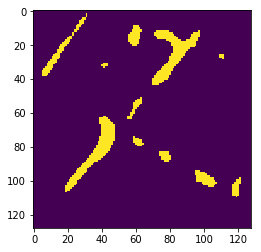

In [14]:
img = true_random_web_image()
#img = true_random_image()[::4, ::4]
plt.imshow(img)
plt.show()
getLines.segment3(img[:, :, :3])

#plt.imshow(numodel.predict(np.expand_dims(cv2.resize(img / 255., (128, 128))[:, :, :3], 0))[0, :, :, 0] > .1)
#plt.show()
plt.imshow(numodel.predict(np.expand_dims(cv2.resize(img / 255., (128, 128))[:, :, :3], 0))[0, :, :, 0] > .5)
plt.show()

In [5]:
patch_size=128
def segment3_getblocks4train(line, graph=True):
    inp = line
    offset = (patch_size - 100) // 2
    line = np.pad(line, ((offset, offset + patch_size //2 + 100),
                         (offset, offset + patch_size //2 + 100),
                         (0, 0)), "reflect")
    shape = line.shape
    
    i_grid, j_grid = np.mgrid[0:shape[0] - patch_size:128, 0:shape[1]-patch_size:128]
    
    B_shape = i_grid.shape
    
    i_grid = i_grid.flatten()
    j_grid = j_grid.flatten()
    blbatch = np.array([
        line[ci:ci + patch_size, cj:cj + patch_size] for ci, cj in zip(i_grid, j_grid)
    ])
    
    
    res = getLines.model.predict(blbatch)
    
    classes = res.reshape((B_shape[0]* B_shape[1], 128, 128, 2))
    return blbatch, classes

In [6]:
import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, Cropping2D
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, concatenate, Add
import keras.backend as K


import keras.utils
from keras.engine.topology import Layer

def nvidia_unet(patch_size=128):
    input_ = Input((patch_size, patch_size, 3))
    skips = []
    output = input_
    for shape, filters in zip([3, 3, 3, 3, 3, 3, 3], [16, 32, 64, 64, 64, 64, 64]):
        skips.append(output)
        print(output.shape)
        output= Conv2D(filters // 3, (shape, shape), strides=2, padding="same", activation="relu")(output)
        #if shape != 7:
        #   output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [64, 64, 64, 64,32, 16, 8]):
        output = keras.layers.UpSampling2D()(output)
        
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        
        if filters != 8:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters // 3, (shape, shape), activation=activation, padding="same")(output)
        
        
            
        #if filters != 3:
        #    output = BatchNormalization()(output)
    assert len(skips) == 0
    return Model([input_], [output])


In [7]:
numodel = nvidia_unet()
numodel.compile(optimizer = keras.optimizers.adam(), loss=keras.losses.mean_squared_error)

(?, 128, 128, 3)
(?, 64, 64, 5)
(?, 32, 32, 10)
(?, 16, 16, 21)
(?, 8, 8, 21)
(?, 4, 4, 21)
(?, 2, 2, 21)


In [ ]:
import cv2

for _ in range(2000):
    try:
        imgs = [true_random_image()[::4, ::4] for _ in range(120)]
        inputs = []
        outputs = []
        for img in imgs:
            #i, o = segment3_getblocks4train(img)
            i = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
            i = i.reshape(1, 128, 128, 3)
            i = np.concatenate([i, np.flip(i, 1)])
            i = np.concatenate([i, np.flip(i, 2)])
            #print(i.shape)
            o = cv2.resize(getLines.segment3(img, graph=False), dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
            o = o.reshape(1, 128, 128, 1)
            o = np.concatenate([o, 1-o], -1)
            
            o = np.concatenate([o, np.flip(o, 1)])
            o = np.concatenate([o, np.flip(o, 2)])
            #print(o.shape)
            scale = np.random.uniform(-1.4, 1.4, (i.shape[0], 1, 1, 1))


            inputs.append((i / 255.) ** ( 2.5 **scale))
            outputs.append(o)
        inputs = np.concatenate(inputs)
        outputs = np.concatenate(outputs)
        numodel.fit(inputs, outputs)
    except OSError as e:
        print(e)
    finally:
        if type(inputs) is list:
            inputs = np.concatenate(inputs)
            outputs = np.concatenate(outputs)

Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0686     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0705     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0723     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0613     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0632     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0616     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0661     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0631     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0596     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0603     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0573     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0592     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0601     
Epoch 1/1
48

480/480 [==============================] - 0s - loss: 0.0360     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0332     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0370     
cannot identify image file '../CameraMotionLogger/Server/website/image_uploads/1536691590.507915.png'
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0344     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0311     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0336     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0367     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0290     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0407     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0328     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0355     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0315  

480/480 [==============================] - 0s - loss: 0.0293     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0371     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0317     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0342     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0319     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0306     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0279     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0353     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0280     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0281     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0317     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0312     
Epoch 1/1
480/480 [==============================] - 0s - loss: 0.0310     
Epoch 1/1
480/480 [===

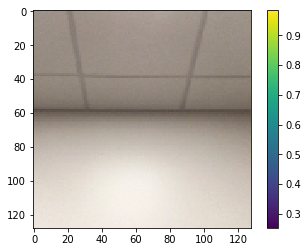

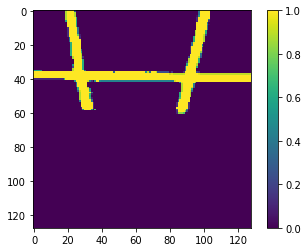

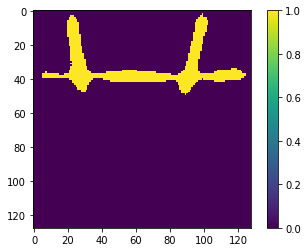

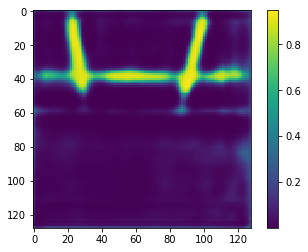

In [9]:
i = np.random.randint(230)
plt.imshow(inputs[i, :, :])
plt.colorbar()
plt.show()
plt.imshow(outputs[i, :, :, 0])
plt.colorbar()
plt.show()
plt.imshow(1.0 * (numodel.predict(inputs[i:i+1])[0, :, :, 0] > .5))
plt.colorbar()
plt.show()
plt.imshow(1.0 * (numodel.predict(inputs[i:i+1])[0, :, :, 0]))
plt.colorbar()
plt.show()

In [186]:
type(inputs) is list

True

In [26]:
img.shape

(213, 160, 3)

In [281]:
numodel.save("web_linefinder")

In [13]:
model = keras.models.load_model("web_linefinder")

In [178]:
numodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_29 (Conv2D)               (None, 64, 64, 5)     140         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_30 (Conv2D)               (None, 32, 32, 10)    460         conv2d_29[0][0]                  
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 16, 16, 21)    1911        conv2d_30[0][0]                  
___________________________________________________________________________________________

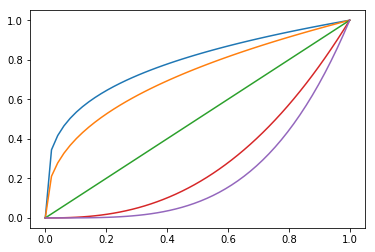

In [89]:
x = np.linspace(0, 1)
a = np.array([[-1.414, -1, 0, 1, 1.414]]).transpose()
plt.plot((x + 0 * a).transpose(), (x**(2.5**a)).transpose())
plt.show()

getlines.model.summary()

In [283]:
getLines.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_24 (Conv2D)               (None, 128, 128, 32)  896         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 128, 128, 32)  9248        conv2d_24[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)   (None, 64, 64, 32)    0           conv2d_25[0][0]                  
___________________________________________________________________________________________

In [286]:
getLines.get_lines(img)

True


ValueError: Expected n_samples >= n_components but got n_components = 2, n_samples = 1

In [287]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [135, 130, 119],
        [136, 129, 119],
        [135, 131, 122]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [138, 131, 121],
        [137, 130, 120],
        [134, 130, 120]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [139, 132, 124],
        [137, 130, 120],
        [134, 129, 119]],

       ...,

       [[106,  93,  83],
        [106,  96,  86],
        [106,  93,  84],
        ...,
        [148, 141, 131],
        [150, 142, 129],
        [150, 141, 128]],

       [[104,  91,  81],
        [109,  99,  87],
        [106,  93,  85],
        ...,
        [152, 144, 132],
        [151, 145, 131],
        [152, 143, 129]],

       [[104,  94,  83],
        [106,  96,  83],
        [107,  94,  85],
        ...,
        [155, 146, 134],
        [150, 144, 130],
        [149, 140, 126]]

In [96]:
i = Image.fromarray(img)
i.save("hose")

ValueError: unknown file extension: 